In [15]:
import pandas as pd
from libs.lib import DataScalerSplitter, GRUTrainerConfig, GRUTrainer

df = pd.read_csv("new_proj_data.csv")

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df.set_index("date", inplace=True)

feature_cols = ['FedFundRate', 'EquityMktVolatility', 'EPU', 
                'EquityMktEPU', 'ExRate', 'LoanRate', 
                'CorBondYield', 'OilPrice', 'NASDAQ']
target = "TreasuryYield"

pre = DataScalerSplitter(features=feature_cols, target=target, scale_target=True)
tr_X, tr_y, vl_X, vl_y, te_X, te_y = pre.split_and_scale(df)

window = 60

cfg = GRUTrainerConfig(
        window      = window,
        hidden_dim  = 128,
        num_layers  = 2,
        dropout     = 0.2,
        max_epochs  = 250,
        patience    = 50,
    )

trainer = GRUTrainer(cfg)
trainer.fit(tr_X, tr_y, vl_X, vl_y, verbose=True)

Epoch 001 | Train 0.181263 | Val 0.045529
Epoch 010 | Train 0.145064 | Val 0.184452
Epoch 020 | Train 0.062311 | Val 0.250737
Epoch 030 | Train 0.062470 | Val 0.212341
Epoch 040 | Train 0.046517 | Val 0.162418
Epoch 050 | Train 0.043209 | Val 0.148060
Early stopping at epoch 51. Best Val: 0.045529


c:\Users\santo\Desktop\new_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


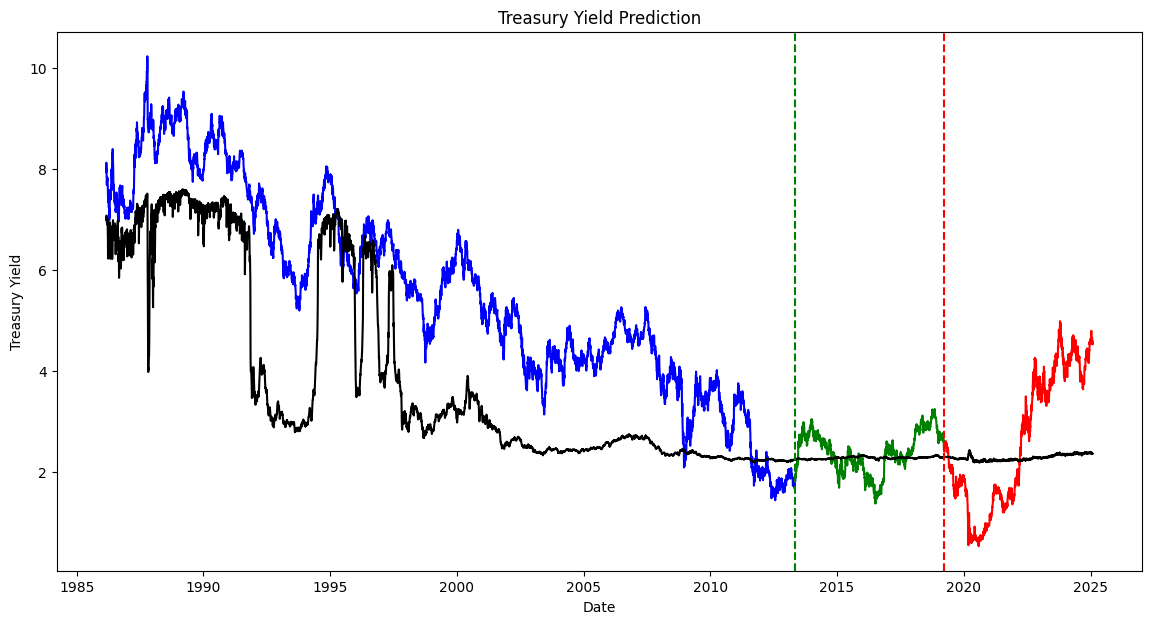

In [ ]:
import matplotlib.pyplot as plt


class PlotResults:
    def __init__(self, val_index, test_index):
        self.val_index = val_index
        self.test_index = test_index

    
    def plot(self, df):

        df_train = df[df["Date"] < self.val_index]
        df_val   = df[(df["Date"] >= self.val_index) & (df["Date"] < self.test_index)]
        df_test  = df[df["Date"] >= self.test_index]

        plt.figure(figsize=(14, 7))

        plt.plot(df_train["Date"], df_train["Actual"], label="Actual (Train)", color="blue")
        plt.plot(df_train["Date"], df_train["Predicted"], label="Predicted (Train)", color="black")

        plt.plot(df_val["Date"], df_val["Actual"], label="Actual (Val)", color="green")
        plt.plot(df_val["Date"], df_val["Predicted"], label="Predicted (Val)", color="black")

        plt.plot(df_test["Date"], df_test["Actual"], label="Actual (Test)", color="red")
        plt.plot(df_test["Date"], df_test["Predicted"], label="Predicted (Test)", color="black")

        plt.axvline(x=self.val_index, color='green', linestyle='--', label='Validation Start')
        plt.axvline(x=self.test_index, color='red', linestyle='--', label='Test Start')

        plt.xlabel("Date")
        plt.ylabel("Treasury Yield")
        plt.title("Treasury Yield Prediction")
        
        plt.show()


preds = pre.inverse_y(trainer.predict(
    pre.transform(df[feature_cols], df[target])[0]
))

pred_df = pd.DataFrame({
    "Date" : df.index[window:],
    "Predicted": preds,
    "Actual": df[target].values[window:]
})

plotter = PlotResults(pre.val_index, pre.test_index)
plotter.plot(pred_df)